In [26]:
import matplotlib.pyplot as plt
import json
import requests
%matplotlib inline

In [49]:
URL_TEMPLATE = "https://apigtw.vaisala.com/hackjunction2018/saunameasurements/history?SensorID={}&before={}&after={}"
sensor_id = "Bench1"
before = "1542910942000"
after =  "1541910942000"
response = requests.get(URL_TEMPLATE.format(sensor_id, before, after))
with open("temperature_{}_{}_{}.csv".format(sensor_id, before, after), "w") as file:
    file.write(response.text)

data = json.loads(response.text)

[{'Measurements': {'Carbon Dioxide concentration': {'unit': 'ppm',
    'value': 397},
   'Temperature': {'unit': '°C', 'value': 12.13}},
  'Timestamp': 1542998462349},
 {'Measurements': {'Carbon Dioxide concentration': {'unit': 'ppm',
    'value': 397},
   'Temperature': {'unit': '°C', 'value': 12.13}},
  'Timestamp': 1542998461478},
 {'Measurements': {'Carbon Dioxide concentration': {'unit': 'ppm',
    'value': 397},
   'Temperature': {'unit': '°C', 'value': 12.13}},
  'Timestamp': 1542998460593},
 {'Measurements': {'Carbon Dioxide concentration': {'unit': 'ppm',
    'value': 397},
   'Temperature': {'unit': '°C', 'value': 12.13}},
  'Timestamp': 1542998459337},
 {'Measurements': {'Carbon Dioxide concentration': {'unit': 'ppm',
    'value': 397},
   'Temperature': {'unit': '°C', 'value': 12.13}},
  'Timestamp': 1542998458338},
 {'Measurements': {'Carbon Dioxide concentration': {'unit': 'ppm',
    'value': 397},
   'Temperature': {'unit': '°C', 'value': 12.13}},
  'Timestamp': 15429984

In [50]:
def get_temp(elem):
    return elem['Measurements']['Temperature']['value']

def get_timestamp(elem):
    return elem['Timestamp']

timestamps = [get_timestamp(x) for x in data]
temps = [get_temp(x) for x in data]

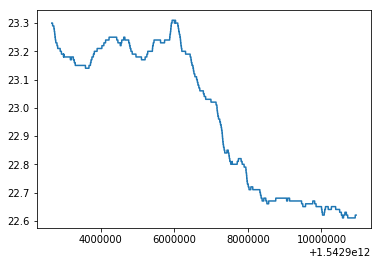

In [51]:
plt.plot(timestamps, temps)